<a href="https://colab.research.google.com/github/PhilipPfeffer/haptic_vest/blob/main/resnet34_oracle_1000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import fastai
from fastai import *
from fastai.vision import *
import os

In [9]:
print(fastai.__version__ )

1.0.61


In [10]:
dataset ='/content/drive/My Drive/Haptic Vest/dataset_person_car'
classes = ['neither', 'person', None , 'car']
download_imgs_dir = '/content/drive/My Drive/Haptic Vest/person_car_other_imgs_processed'

In [11]:
train_ids = np.loadtxt(dataset, dtype=(int, int))

In [12]:
x_train_ids, y_train_ids = train_ids[:,0], train_ids[:,1]
assert(x_train_ids.shape == y_train_ids.shape)
x_train_ids[0], y_train_ids[0]
print(f"There are {len(x_train_ids)} images, set(x_train_ids) = {len(set(x_train_ids))} images")

There are 77650 images, set(x_train_ids) = 77033 images


In [13]:
train_ids_dict = dict(train_ids)

In [14]:
fnames = get_image_files(download_imgs_dir)
# len(fnames)
# train_ids_dict[int(fnames[0].parts[-1][:-4])]
labels = [train_ids_dict[int(fname.parts[-1][:-4])] for fname in fnames]
print(sum(labels))


44405


# Get dataset_1000 from zip


In [30]:
# !apt install unzip

In [34]:
zip_path = '/content/processed_subset1000-20201022T150258Z-001'
dataset_1000_parent = '/content/dataset_1000'
dataset_1000 = '/content/dataset_1000/processed_subset1000/'
# !mkdir dataset_1000
# !unzip '/content/processed_subset1000-20201022T150258Z-001.zip' -d dataset_1000_parent

In [50]:
dataset_1000_ids = {}
for entry in os.scandir(dataset_1000):
  if os.path.basename(entry)[0] == '.':
    continue
  dataset_1000_ids[int(os.path.basename(entry)[:-4])] = train_ids_dict[int(os.path.basename(entry)[:-4])]
len(dataset_1000_ids)

2984

In [54]:
dataset_1000_fnames = get_image_files(dataset_1000)
dataset_1000_labels = [train_ids_dict[int(fname.parts[-1][:-4])] for fname in dataset_1000_fnames]
print(sum(dataset_1000_labels))


2984


## Make databunch_1000


In [55]:
dls = ImageDataBunch.from_lists(dataset_1000, dataset_1000_fnames, dataset_1000_labels)
print(dls)

ImageDataBunch;

Train: LabelList (2388 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
3,1,0,0,0
Path: /content/dataset_1000/processed_subset1000;

Valid: LabelList (596 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,1,3,1
Path: /content/dataset_1000/processed_subset1000;

Test: None


([0, 1, 3], 3, 2388, 596)

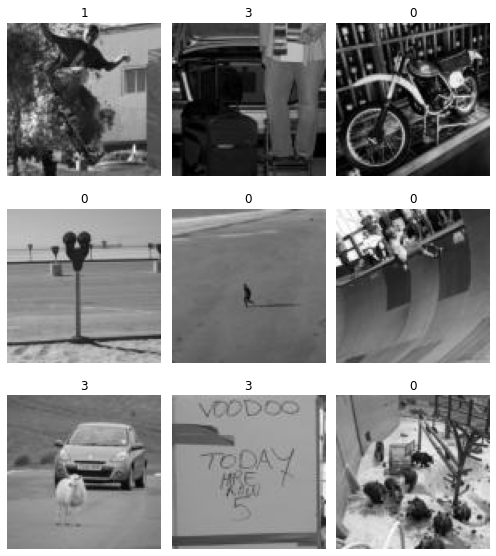

In [56]:
np.random.seed(42)
dls_norm = dls.normalize(imagenet_stats)

dls_norm.classes

dls_norm.show_batch(rows=3, figsize=(7,8))
dls_norm.classes, dls_norm.c, len(dls_norm.train_ds), len(dls_norm.valid_ds)

## Stage 1

In [62]:
learner_1000 = cnn_learner(dls_norm, models.resnet34, metrics=[error_rate, accuracy])

In [63]:
learner_1000.fit_one_cycle(40)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.720730,1.150381,0.474832,0.525168,00:02
1,1.429225,0.963206,0.407718,0.592282,00:02
2,1.236211,0.917620,0.374161,0.625839,00:02
3,1.125203,0.932832,0.375839,0.624161,00:02
4,1.009739,0.953911,0.360738,0.639262,00:02
5,0.900248,0.928827,0.364094,0.635906,00:02
6,0.813194,0.924878,0.345638,0.654362,00:02
7,0.744115,0.923451,0.355705,0.644295,00:02
8,0.664131,0.967343,0.362416,0.637584,00:02
9,0.588149,0.960033,0.347315,0.652685,00:02


In [64]:
learner_1000.save('stage-1')


In [70]:
interp = ClassificationInterpretation.from_learner(learner_1000)

losses,idxs = interp.top_losses()

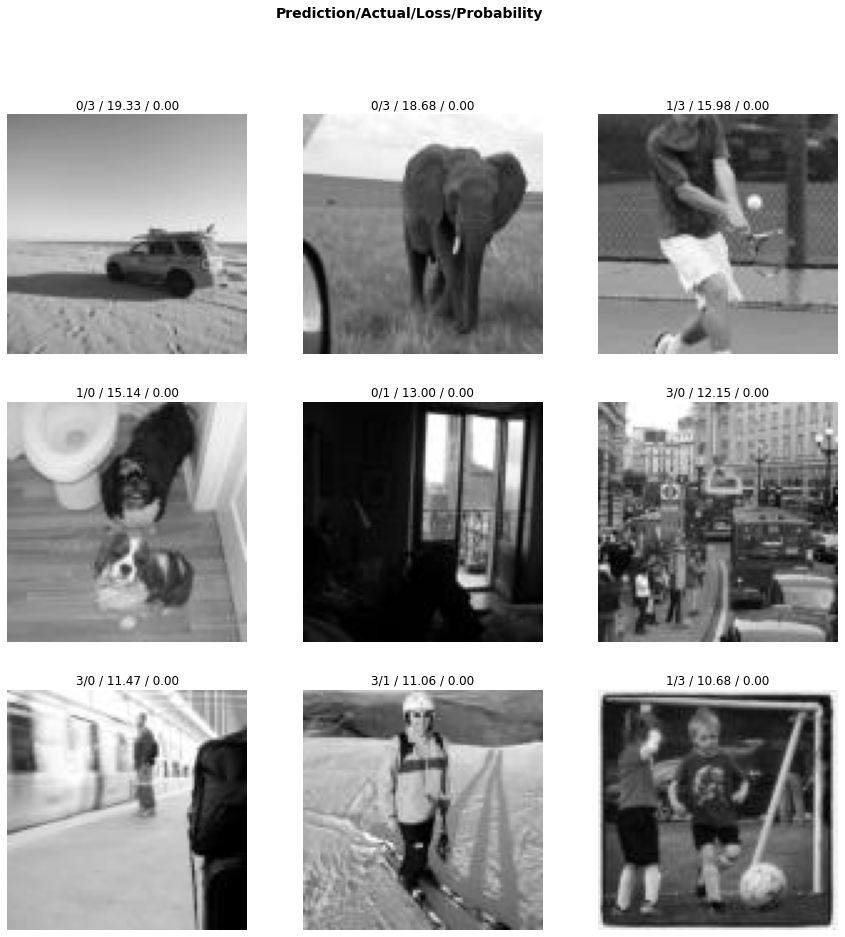

In [71]:
interp.plot_top_losses(9, figsize=(15,15), heatmap=True)


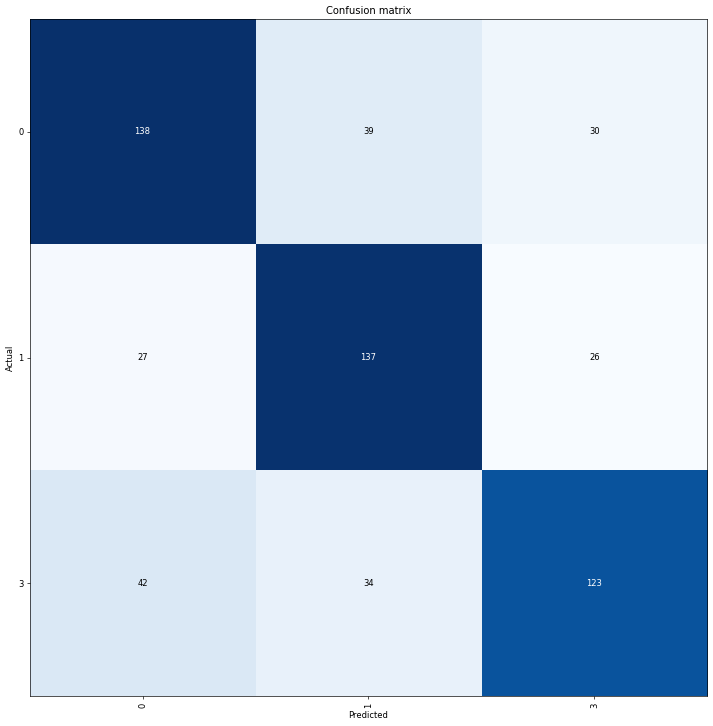

In [72]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


## Stage 2

In [68]:
learner_1000.load('stage-1');

In [73]:
learner_1000.unfreeze()

In [74]:
learner_1000.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


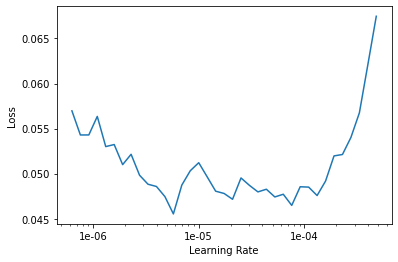

In [76]:
learner_1000.recorder.plot()


In [77]:
learner_1000.fit_one_cycle(20, max_lr=slice(3e-6,3e-4))


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.053644,1.382316,0.332215,0.667785,00:03
1,0.053410,1.389637,0.328859,0.671141,00:03
2,0.049387,1.367181,0.332215,0.667785,00:03
3,0.045680,1.415057,0.325503,0.674497,00:03
4,0.048256,1.490267,0.337248,0.662752,00:03
5,0.043226,1.403179,0.327181,0.672819,00:03
6,0.040912,1.497902,0.327181,0.672819,00:03
7,0.041070,1.458659,0.313758,0.686242,00:03
8,0.042460,1.398232,0.322148,0.677852,00:03
9,0.041075,1.432265,0.322148,0.677852,00:03


In [78]:
learner_1000.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


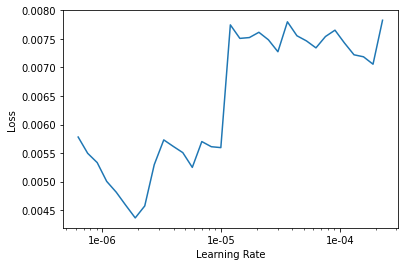

In [79]:
learner_1000.recorder.plot()


In [80]:
learner_1000.save('stage-2')


# Stage 3

In [81]:
learner_1000.load('stage-2');

In [82]:
learner_1000.fit_one_cycle(20, max_lr=slice(3e-7,3e-6))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.005604,1.424836,0.302013,0.697987,00:03
1,0.008705,1.424575,0.305369,0.694631,00:03
2,0.008046,1.407284,0.291946,0.708054,00:03
3,0.007221,1.422912,0.308725,0.691275,00:03
4,0.007923,1.436480,0.296980,0.703020,00:03
5,0.006767,1.444260,0.302013,0.697987,00:03
6,0.006128,1.442994,0.305369,0.694631,00:03
7,0.007349,1.418435,0.307047,0.692953,00:03
8,0.007035,1.420400,0.307047,0.692953,00:03
9,0.006216,1.408561,0.300336,0.699664,00:03


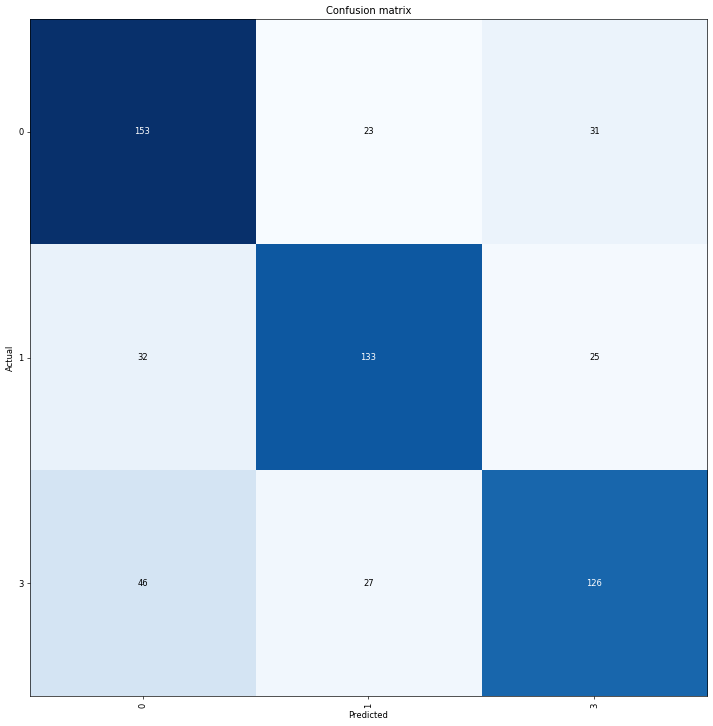

In [86]:
interp = ClassificationInterpretation.from_learner(learner_1000)

losses,idxs = interp.top_losses()
# interp.plot_top_losses(9, figsize=(15,15), heatmap=True)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Cleanup dataset_1000

In [85]:
from fastai.widgets import *

In [95]:
databunch_1000_clean = ImageDataBunch.from_lists(dataset_1000, dataset_1000_fnames, dataset_1000_labels)


In [102]:
learn_clean_1000 = cnn_learner(databunch_1000_clean, models.resnet34, metrics=error_rate)

learn_clean_1000.load('stage-2');

In [103]:
ds_1000, idxs_1000 = DatasetFormatter().from_toplosses(learn_clean_1000)

In [104]:
ImageCleaner(ds_1000, idxs_1000, dataset_1000)


Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

([0, 1, 3], 3, 1908, 477)

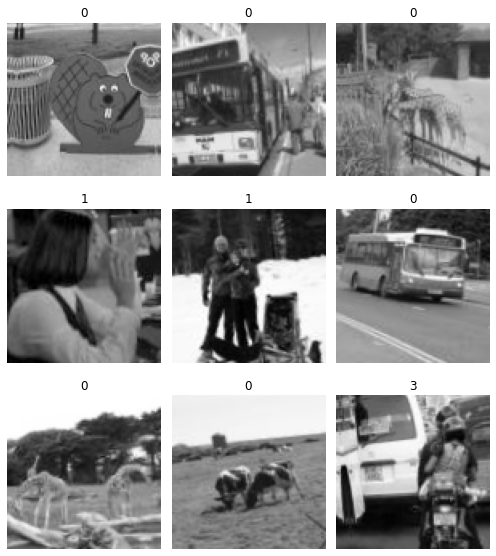

In [106]:
np.random.seed(42)
dataset_1000_clean = ImageDataBunch.from_csv(dataset_1000, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=96, num_workers=4).normalize(imagenet_stats)

dataset_1000_clean.classes

dataset_1000_clean.show_batch(rows=3, figsize=(7,8))
dataset_1000_clean.classes, dataset_1000_clean.c, len(dataset_1000_clean.train_ds), len(dataset_1000_clean.valid_ds)

In [112]:
learn_clean_1000 = cnn_learner(dataset_1000_clean, models.resnet34, metrics=[error_rate, accuracy])

In [113]:
learn_clean_1000.fit_one_cycle(20, max_lr=3e-3)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.666828,1.195112,0.461216,0.538784,00:05
1,1.408938,1.058743,0.394130,0.605870,00:04
2,1.260823,1.100501,0.373166,0.626834,00:04
3,1.169796,1.143753,0.360587,0.639413,00:04
4,1.056329,1.062009,0.362683,0.637317,00:04
5,0.952983,0.938416,0.335430,0.664570,00:04
6,0.838108,0.902845,0.329140,0.670860,00:04
7,0.754998,0.871345,0.329140,0.670860,00:04
8,0.701108,0.881487,0.318658,0.681342,00:04
9,0.650690,0.840747,0.299790,0.700210,00:04
